In [1]:
import scvelo as scv

没有运行错误说明scVelo成功安装

读取数据 ( scv.read) 或加载内置数据集 ( scv.datasets.*) 

In [2]:
# adata = scv.datasets.dentategyrus()
# adata = scv.datasets.pancreatic_endocrinogenesis()
# adata

In [3]:
# adata = scv.datasets.pancreas()

由于网络、代理、ip等之类的问题导致无法获取到这个数据集，我尝试将数据集下载

In [4]:
adata = scv.read('E:/scvelo_notebooks-master/data/Pancreas/endocrinogenesis_day15.h5ad', cache=True)
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

adata存储了数据矩阵（adata.X）、细胞/观测（adata.obs）和基因/变量（adata.var）、非结构化注释（adata.uns如图形）和剪切和未剪切计数的其他数据（adata.layers）。

过滤、标准化、对数转换。min_shared_counts表示一个基因所需的最小计数数(包括未剪接数和剪接数)，并选取前2000个高变基因

In [5]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


基于主成分分析空间(有30个主成分)对对数拼接计数的欧氏距离计算了一个最近邻图(有30个邻居)。每个细胞通过其最近的邻居计算一阶/二阶矩

In [6]:
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)

computing neighbors
    finished (0:00:14) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


稳态模型计算速度

In [8]:
scv.tl.velocity(adata, mode='steady_state')

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


恢复特定基因的完整剪接动力学。
该模型通过期望最大化迭代估计转录速率、剪接速率、降解速率以及细胞特异性潜伏时间和转录状态。

In [10]:
scv.tl.recover_dynamics(adata)

recovering dynamics (using 1/12 cores)


  0%|          | 0/1038 [00:00<?, ?gene/s]

    finished (0:09:24) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


RNA速度可以使用推断剪接动力学的明确描述来估计。

In [12]:
scv.tl.velocity(adata, mode='dynamical')

computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [13]:
adata

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'fit_r2'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'velocity_params', 'recover_dynamics'
    obsm: 'X_pca', 'X_umap'
    varm: 'loss'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity_u'
    obsp: 'distances', 'connectivities'

速率通过将它们转换成可能的细胞转换投射到低维嵌入中。即，对于每个速率矢量，我们发现符合该方向的可能的细胞过渡。一个细胞过渡到另一个细胞的概率是使用（潜在细胞过渡和速率矢量之间）余弦值相关性计算的，并存储在矩阵中，使用速率图展示：

In [15]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/12 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


最后，为了增强鲁棒性，通过将基因共享的潜伏时间过程与其邻域卷积进行回归，我们检测出不一致的时间点，并将其替换为其卷积。

In [18]:
scv.tl.recover_latent_time(adata)

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


速率被投影到任何嵌入，通过basis指定，并以以下方式之一可视化：
细胞水平 scv.pl.velocity_embedding，
网格线scv.pl.velocity_embedding_grid
流线型scv.pl.velocity_embedding_stream

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


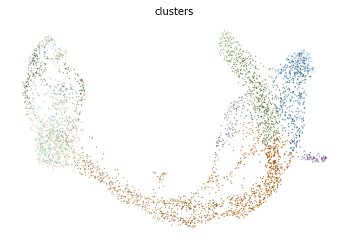

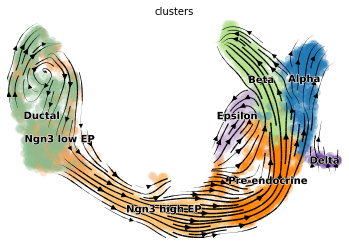

In [20]:
scv.pl.velocity_embedding(adata, basis='umap')
scv.pl.velocity_embedding_stream(adata, basis='umap')

流线显示的速率矢量可对发育过程进行详细分析。它准确地勾画了导管细胞和内分泌祖细胞的循环。此外，它阐明了细胞的谱系命运、细胞周期回归和内分泌细胞分化状态。

在单细胞水平上获得的速率矢量的最详细分辨率，每个箭头显示单个细胞运动的方向和速率。这揭示了 Ngn3 细胞（黄色）的早期内分泌命运，以及近端α细胞（蓝色）和瞬态β细胞（绿色）之间的明显差异。

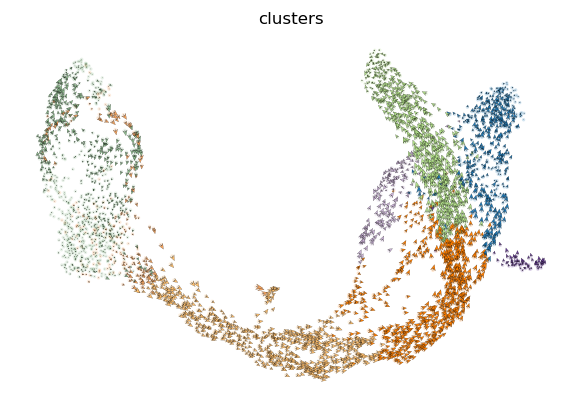

In [21]:
scv.pl.velocity_embedding(adata, arrow_length=3, arrow_size=2, dpi=120)

用随机模型计算速度

In [24]:
scv.tl.velocity(adata, mode='stochastic')

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


下面是（在别的博客上看到的）

### 解释速度
基因活动是由转录调节的。特定基因的转录诱导导致（新转录的）前体未剪切 mRNA 增加，而相反，抑制或没有转录会导致未转录 mRNA 的减少。拼接的 mRNA 由未剪切的 mRNA 生成，并遵循相同的趋势，并具有时滞。时间是一个隐藏/潜在的变量。因此，需要从实际测量中推断出动态：相像中显示的剪切和未剪切的 mRNA。

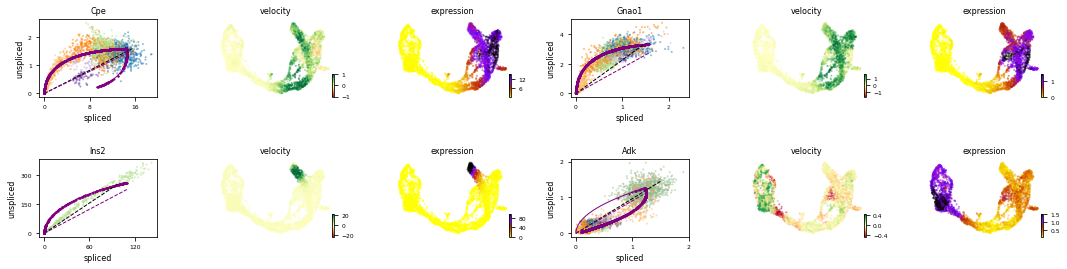

In [26]:
scv.pl.velocity(adata, ['Cpe',  'Gnao1', 'Ins2', 'Adk'], ncols=2)

黑线对应于估计的"稳定状态"比率，即未剪切与剪切的 mRNA 丰度之比，后者处于恒定的转录状态。特定基因的RNA速率被确定为残留的，即观察与稳定状态线的偏差程度。正速率表示基因被向上调节，这发生在细胞显示该基因的未剪切mRNA的丰度高于预期的稳定状态。相反，负速表示基因被降低调节。

例如，Cpe解释了上调节 Ngn3（黄色）到前内分泌（橙色）到β细胞（绿色）的方向，而Adk则解释了向下调节的Ductal（深绿色）到 Ngn3（黄色）到剩余内分泌细胞的方向。

### 速率图和伪时间
我们可以可视化速率图，以描绘所有速率推断的细胞到细胞连接/过渡。它可以通过设置 threshold.限制在高概率转换。例如，该图指示来自早期和晚期内分泌细胞的 Epsilon 细胞产生的两个阶段。

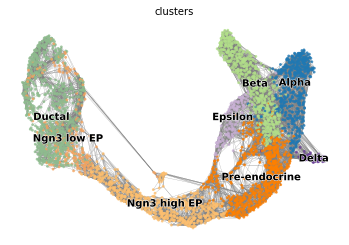

In [27]:
scv.pl.velocity_graph(adata, threshold=.1)